In [1]:
import os
from os.path import realpath, join
import sys
sys.path.insert(0, '/home/chuah/mitsuba3-camera/build/python')

import drjit as dr
import mitsuba as mi
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

# mi.set_variant('cuda_ad_rgb')
mi.set_variant('cuda_ad_dispersion')

In [2]:
SCENE_DIR = realpath('../tutorials/scenes')

# Make sure that resources from the scene directory can be found
mi.Thread.thread().file_resolver().append(SCENE_DIR)

In [3]:
output_dir = realpath(join('.', 'outputs', 'lens'))
os.makedirs(output_dir, exist_ok=True)
print('[i] Results will be saved to:', output_dir)

[i] Results will be saved to: /home/chuah/mitsuba3-camera/notebooks/outputs/lens


# Set lens parameters

In [4]:
# from scripts.lens_design.lens import ConicSurface, EvenAsphericSurface, LensMaterial, LensSystem


# # BFL = FFL = 325.439588
# surf0 = { 'c': -0.3, 'K': 0.0, 'z0': 2.5 }
# surf1 = { 'c': 0.3,  'K': 0.0, 'z0': 2.8 }

# # # RayOptics BFL = 280.743881, FFL = 276.563327
# # surf0 = { 'c': -0.277226358652119, 'K': 0.0, 'z0': 2.5 }
# # surf1 = { 'c':  0.421164870262146, 'K': 0.0, 'z0': 2.8 }

# # surf0 = {'c': -0.28128084540367126, 'K': -0.3558797538280487, 'z0': 2.593641996383667}
# # surf1 = {'c': 0.3993512690067291, 'K': -0.44850954413414, 'z0': 3.19931960105896}

# # surf0 = ConicSurface(**surf0)
# # surf1 = ConicSurface(**surf1)
# surf0 = EvenAsphericSurface(**surf0)
# surf1 = EvenAsphericSurface(**surf1)

# surfaces = [surf0, surf1]
# radial_extents = [0.8 for _ in surfaces]
# materials = [LensMaterial("nbk7", 1.5047, 64.17)]

# target_focal_length = 2.0

# lens_system = LensSystem(surfaces, radial_extents, materials)
# # lens_system.initialize_geometry(output_dir)
# lens_system.disable_all_materials()
# lens_system.disable_surface_vars("z0")
# lens_system.disable_surface_vars("K")

# # apply focal length constraint
# s1_params = lens_system.get_rear_surface_params(target_focal_length)
# lens_system.elements[0].surface.params['c'] = s1_params['c']
# lens_system.elements[0].surface.params['z0'] = s1_params['z0']
# lens_system.build_paraxial_matrices()

# print("Focal length target: ", 
#         lens_system.compute_EFL(), " vs. ",
#         target_focal_length)
# print("BFL focus target: ", 
#         lens_system.compute_BFL(), " vs. ",
#         lens_system.elements[0].surface.params['z0'])

In [5]:
from scripts.lens_design.lens import ConicSurface, EvenAsphericSurface, LensMaterial, LensSystem

surfs = [
        { 'c': -17.285, 'z0': 42.95 },
        { 'c': 141.25,  'z0': 44.95 },
        { 'c': 19.3,    'z0': 50.95 },
        { 'c': -20.25,  'z0': 51.95 },
        { 'c': -158.65, 'z0': 57.95 },
        { 'c': 21.25,   'z0': 59.95 },
        ]
for surf in surfs:
        surf['c'] = 1.0 / surf['c']

# surfaces = [ConicSurface(K=0, **surf) for surf in surfs]
surfaces = [EvenAsphericSurface(K=0, **surf) for surf in surfs]
radial_extents = [6.5, 6.5, 5.0, 5.0, 6.5, 6.5]
materials = [LensMaterial("sk16", 1.62041, 60.32), 
             LensMaterial(), 
             LensMaterial("f4", 1.616592, 36.63), 
             LensMaterial(), 
             LensMaterial("sk16", 1.62041, 60.32)]
lens_system = LensSystem(surfaces, radial_extents, materials, aperture_index=2)

target_focal_length = 50.0
lens_system.disable_all_materials()
# lens_system.disable_surface_vars("z0")
# lens_system.disable_surface_vars("K")
# lens_system.disable_surface_vars("c")
lens_system.disable_surface_vars("a16")
lens_system.disable_surface_vars("a14")
lens_system.disable_surface_vars("a12")
lens_system.disable_surface_vars("a10")
lens_system.disable_surface_vars("a8")
lens_system.disable_surface_vars("a6")        # remove to get good perf again
# lens_system.disable_surface_vars("a4")

# # apply focal length constraint
# s1_params = lens_system.get_rear_surface_params(target_focal_length)
# lens_system.elements[0].surface.params['c'] = s1_params['c']
# lens_system.elements[0].surface.params['z0'] = s1_params['z0']
# lens_system.compute_paraxial_quantities()

print("Focal length target: ", 
        lens_system.compute_EFL(), " vs. ",
        target_focal_length)
print("BFL focus target: ", 
        lens_system.compute_BFL(), " vs. ",
        lens_system.elements[0].surface.params['z0'])

print("Exit pupil position: ", lens_system.rear_z - lens_system.exit_pupil_position)
print("Entrance pupil position: ", lens_system.front_z - lens_system.entrance_pupil_position)

Focal length target:  [50.04488754272461]  vs.  50.0
BFL focus target:  [43.12704086303711]  vs.  42.95
Exit pupil position:  -10.067940521240232
Entrance pupil position:  10.464663696289065


In [6]:
# from scripts.lens_design.lens import ConicSurface, EvenAsphericSurface, LensMaterial, LensSystem

# surfs = [
#         { 'c': -0.4, 'z0': 2.5 },
#         { 'c':  0.4, 'z0': 2.8 },
#         { 'c': 0.1,  'z0': 3.1 }]

# surfaces = [EvenAsphericSurface(K=0, **surf) for surf in surfs]
# radial_extents = [1.0 for _ in surfaces]
# materials = [LensMaterial("sk16", 1.62041, 60.32), 
#              LensMaterial("f4", 1.616592, 36.63)]
# lens_system = LensSystem(surfaces, radial_extents, materials)

# target_focal_length = 2.0
# lens_system.disable_all_materials()
# lens_system.disable_surface_vars("z0")

# # lens_system.disable_surface_vars("K")

# # apply focal length constraint
# s1_params = lens_system.get_rear_surface_params(target_focal_length)
# lens_system.elements[0].surface.params['c'] = s1_params['c']
# lens_system.elements[0].surface.params['z0'] = s1_params['z0']
# lens_system.build_paraxial_matrices()

# print("Focal length target: ", 
#         lens_system.compute_EFL(), " vs. ",
#         target_focal_length)
# print("BFL focus target: ", 
#         lens_system.compute_BFL(), " vs. ",
#         lens_system.elements[0].surface.params['z0'])

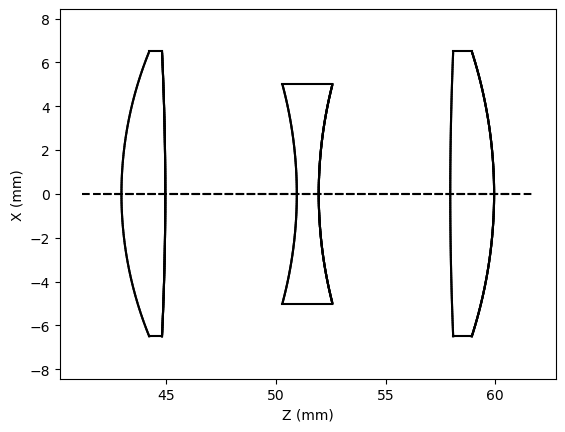

In [7]:
_ = lens_system.draw_cross_section(64)

Focal length target:  [49.9999885559082]  vs.  50.0
BFL focus target:  [43.0534553527832]  vs.  43.05345916748047
V_ lies on sphere: True
[+] Wrote lens mesh (subdivs=7) file to: /home/chuah/mitsuba3-camera/notebooks/outputs/lens/lens0.ply
[+] Wrote baffle mesh file to: /home/chuah/mitsuba3-camera/notebooks/outputs/lens/baffle0.ply
V_ lies on sphere: True
[+] Wrote lens mesh (subdivs=7) file to: /home/chuah/mitsuba3-camera/notebooks/outputs/lens/lens1.ply
[+] Wrote baffle mesh file to: /home/chuah/mitsuba3-camera/notebooks/outputs/lens/baffle1.ply
V_ lies on sphere: True
[+] Wrote lens mesh (subdivs=7) file to: /home/chuah/mitsuba3-camera/notebooks/outputs/lens/lens2.ply
[+] Wrote baffle mesh file to: /home/chuah/mitsuba3-camera/notebooks/outputs/lens/baffle2.ply
V_ lies on sphere: True
[+] Wrote lens mesh (subdivs=7) file to: /home/chuah/mitsuba3-camera/notebooks/outputs/lens/lens3.ply
[+] Wrote baffle mesh file to: /home/chuah/mitsuba3-camera/notebooks/outputs/lens/baffle3.ply
V_ lie

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.0016724318265914917]
y is close:  False
[3.3992575481534004e-05]
u is close:  False


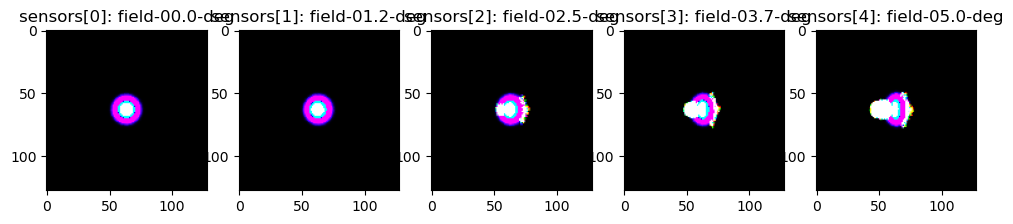

In [8]:
from scripts.lens_design.design_problem import ConstrainedEFLProblem

problem = ConstrainedEFLProblem(
    lens_system,
    resolution=(128, 128),
    spp=64*4,
    learning_rate=0.05e-5,
    iters=300,
    target_focal_length=target_focal_length,
    output_dir=output_dir,
    )

problem.prepare()

In [9]:
spots_init = problem.render(spp = 512, resolution = (1024, 1024), zoom_factor=0.1, sensor_idx=0)
# plt.figure(figsize=(12,12))
# plt.imshow(spots_init)

# mi.util.write_bitmap("spots_.exr", spots_init)

In [10]:
losses, images_final, images_init, upsample_steps = problem.optimize()

# _ = lens_system.draw_cross_section(64)
# plt.figure()
# for i,image in enumerate(images_final):
#     plt.subplot(3,1,i + 1)
#     plt.imshow(0.001 * image)

2024-05-15 22:59:22 WARN main [Mesh] Mesh::build_directed_edges(): there are 1280 non-manifold vertices in the follwing mesh: PLYMesh[
2024-05-15 22:59:22 WARN main [Mesh] name = "baffle0.ply",
2024-05-15 22:59:22 WARN main [Mesh] bbox = BoundingBox3f[
2024-05-15 22:59:22 WARN main [Mesh] min = [-7.15, -7.15, 44.3241],
2024-05-15 22:59:22 WARN main [Mesh] max = [7.15, 7.15, 44.3241]
2024-05-15 22:59:22 WARN main [Mesh] ],
2024-05-15 22:59:22 WARN main [Mesh] vertex_count = 1280,
2024-05-15 22:59:22 WARN main [Mesh] vertices = [30 KiB of vertex data],
2024-05-15 22:59:22 WARN main [Mesh] face_count = 2560,
2024-05-15 22:59:22 WARN main [Mesh] faces = [30 KiB of face data],
2024-05-15 22:59:22 WARN main [Mesh] face_normals = 0
2024-05-15 22:59:22 WARN main [Mesh] ]

2024-05-15 22:59:22 WARN main [Mesh] Mesh::build_directed_edges(): there are 1280 non-manifold vertices in the follwing mesh: PLYMesh[
2024-05-15 22:59:22 WARN main [Mesh] name = "baffle5.ply",
2024-05-15 22:59:22 WARN main [Mesh] bbox = BoundingBox3f[
2024-05-15 22:59:22 WARN main [Mesh] min = [-7.15, -7.15, 58.9315],
2024-05-15 22:59:22 WARN main [Mesh] max = [7.15, 7.15, 58.9315]
2024-05-15 22:59:22 WARN main [Mesh] ],
2024-05-15 22:59:22 WARN main [Mesh] vertex_count = 1280,
2024-05-15 22:59:22 WARN main [Mesh] vertices = [30 KiB of vertex data],
2024-05-15 22:59:22 WARN main [Mesh] face_count = 2560,
2024-05-15 22:59:22 WARN main [Mesh] faces = [30 KiB of face data],
2024-05-15 22:59:22 WARN main [Mesh] face_normals = 0
2024-05-15 22:59:22 WARN main [Mesh] ]

2024-05-15 22:59:22 WARN main [Mesh] Mesh::build_directed_edges(): there are 1280 non-manifold vertices in the follwing mesh: PLYMesh[
2024-05-15 22:59:22 WARN main [Mesh] name = "baffle4.ply",
2024-05-15 22:59:22 WARN main [Mesh] bbox = BoundingBox3f[
2024-05-15 22:59:22 WARN main [Mesh] min = [-7.15, -7.15, 58.0832],
2024-05-15 22:59:22 WARN main [Mesh] max = [7.15, 7.15, 58.0832]
2024-05-15 22:59:22 WARN main [Mesh] ],
2024-05-15 22:59:22 WARN main [Mesh] vertex_count = 1280,
2024-05-15 22:59:22 WARN main [Mesh] vertices = [30 KiB of vertex data],
2024-05-15 22:59:22 WARN main [Mesh] face_count = 2560,
2024-05-15 22:59:22 WARN main [Mesh] faces = [30 KiB of face data],
2024-05-15 22:59:22 WARN main [Mesh] face_normals = 0
2024-05-15 22:59:22 WARN main [Mesh] ]

2024-05-15 22:59:22 WARN main [Mesh] Mesh::build_directed_edges(): there are 1280 non-manifold vertices in the follwing mesh: PLYMesh[
2024-05-15 22:59:22 WARN main [Mesh] name = "baffle3.ply",
2024-05-15 22:59:22 WARN main [Mesh] bbox = BoundingBox3f[
2024-05-15 22:59:22 WARN main [Mesh] min = [-5.5, -5.5, 52.577],
2024-05-15 22:59:22 WARN main [Mesh] max = [5.5, 5.5, 52.577]
2024-05-15 22:59:22 WARN main [Mesh] ],
2024-05-15 22:59:22 WARN main [Mesh] vertex_count = 1280,
2024-05-15 22:59:22 WARN main [Mesh] vertices = [30 KiB of vertex data],
2024-05-15 22:59:22 WARN main [Mesh] face_count = 2560,
2024-05-15 22:59:22 WARN main [Mesh] faces = [30 KiB of face data],
2024-05-15 22:59:22 WARN main [Mesh] face_normals = 0
2024-05-15 22:59:22 WARN main [Mesh] ]

2024-05-15 22:59:22 WARN main [Mesh] Mesh::build_directed_edges(): there are 1280 non-manifold vertices in the follwing mesh: PLYMesh[
2024-05-15 22:59:22 WARN main [Mesh] name = "baffle2.ply",
2024-05-15 22:59:22 WARN main [Mesh] bbox = BoundingBox3f[
2024-05-15 22:59:22 WARN main [Mesh] min = [-5.5, -5.5, 50.2911],
2024-05-15 22:59:22 WARN main [Mesh] max = [5.5, 5.5, 50.2911]
2024-05-15 22:59:22 WARN main [Mesh] ],
2024-05-15 22:59:22 WARN main [Mesh] vertex_count = 1280,
2024-05-15 22:59:22 WARN main [Mesh] vertices = [30 KiB of vertex data],
2024-05-15 22:59:22 WARN main [Mesh] face_count = 2560,
2024-05-15 22:59:22 WARN main [Mesh] faces = [30 KiB of face data],
2024-05-15 22:59:22 WARN main [Mesh] face_normals = 0
2024-05-15 22:59:22 WARN main [Mesh] ]

2024-05-15 22:59:22 WARN main [Mesh] Mesh::build_directed_edges(): there are 1280 non-manifold vertices in the follwing mesh: PLYMesh[
2024-05-15 22:59:22 WARN main [Mesh] name = "baffle1.ply",
2024-05-15 22:59:22 WARN main [Mesh] bbox = BoundingBox3f[
2024-05-15 22:59:22 WARN main [Mesh] min = [-7.15, -7.15, 44.8004],
2024-05-15 22:59:22 WARN main [Mesh] max = [7.15, 7.15, 44.8004]
2024-05-15 22:59:22 WARN main [Mesh] ],
2024-05-15 22:59:22 WARN main [Mesh] vertex_count = 1280,
2024-05-15 22:59:22 WARN main [Mesh] vertices = [30 KiB of vertex data],
2024-05-15 22:59:22 WARN main [Mesh] face_count = 2560,
2024-05-15 22:59:22 WARN main [Mesh] faces = [30 KiB of face data],
2024-05-15 22:59:22 WARN main [Mesh] face_normals = 0
2024-05-15 22:59:22 WARN main [Mesh] ]

Iter 0: upsampling to level 1 due to loss[0] = 0.7577447295188904
[23.40182876586914]
Iter 6: upsampling to level 2 due to loss[0] = 0.6364358067512512
[11.824193954467773]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


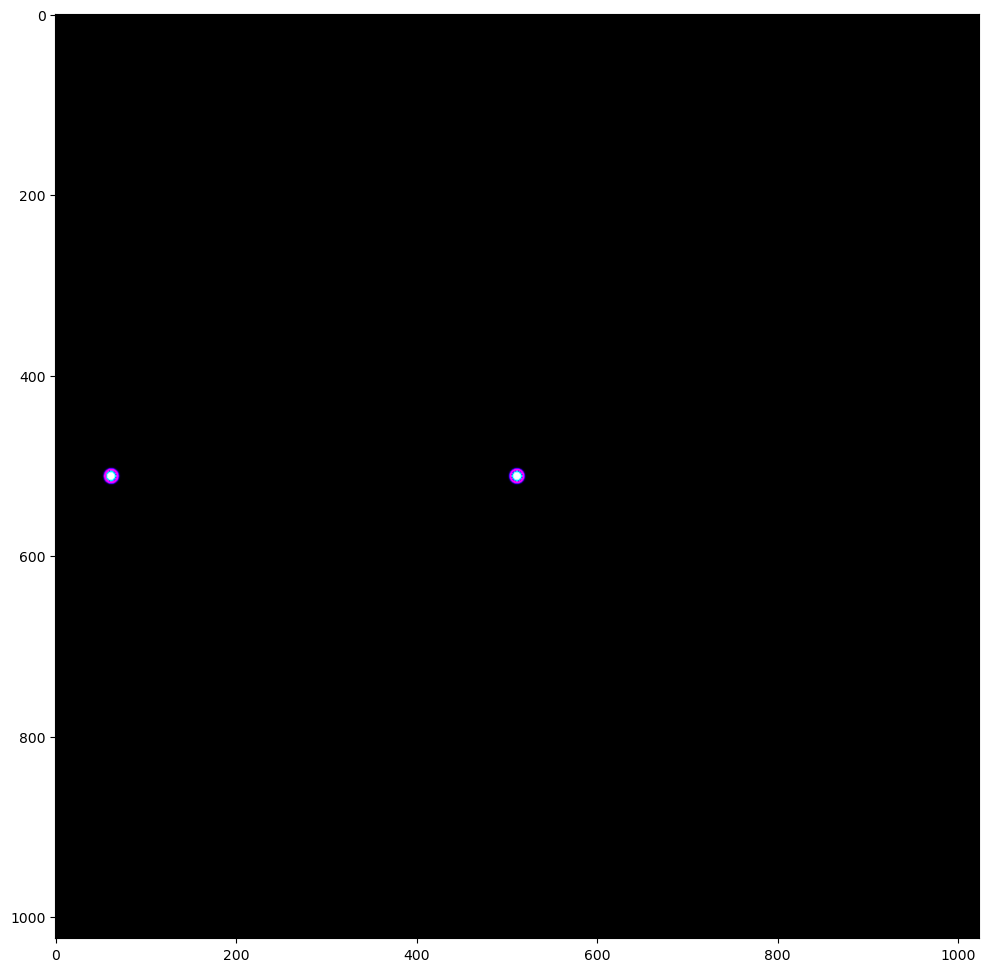

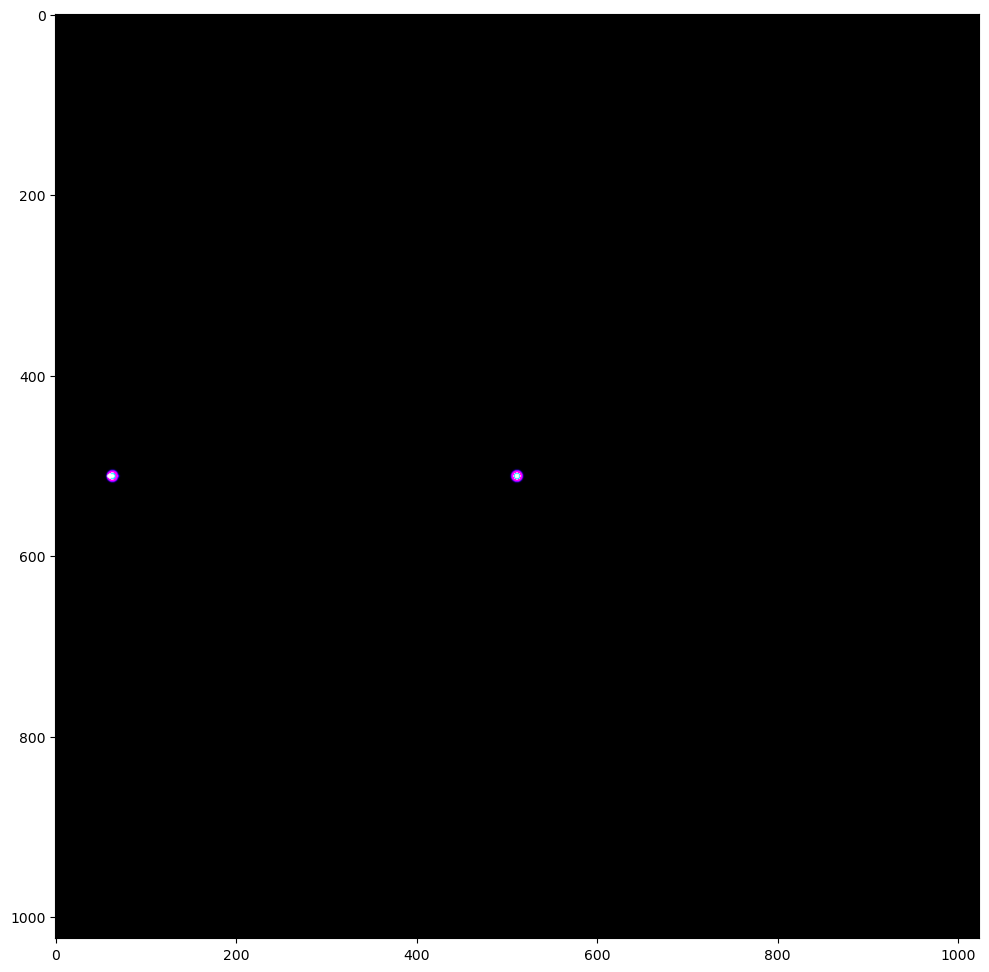

In [11]:
spots_final = problem.render(spp = 512, resolution = (1024, 1024), zoom_factor=0.1 / 2 ** upsample_steps)
plt.figure(figsize=(12,12))
plt.imshow(0.1 * spots_init)
plt.figure(figsize=(12,12))
plt.imshow(0.1 * spots_final)

# mi.util.write_bitmap("spots.exr", spots_final)

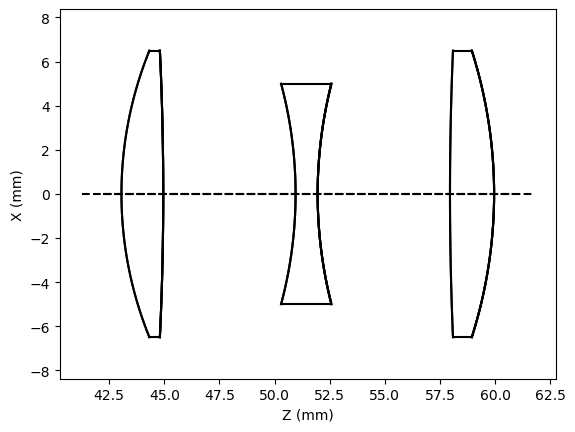

In [12]:
_ = lens_system.draw_cross_section(64)

In [13]:
print(f"Upsampling steps: {upsample_steps}")

Upsampling steps: 2


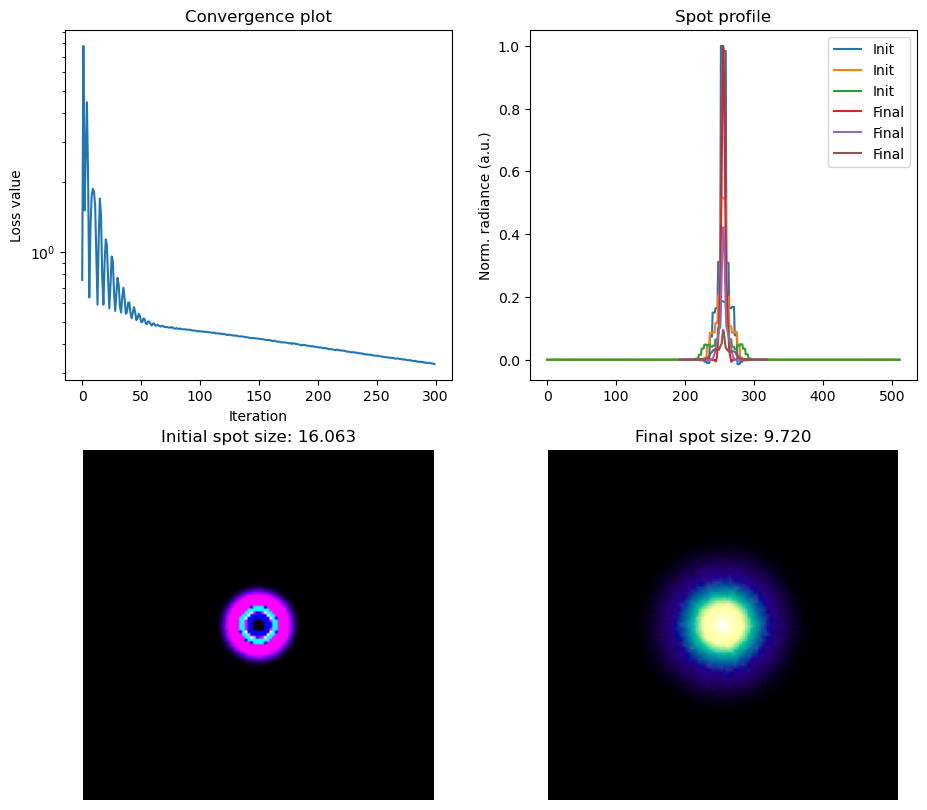

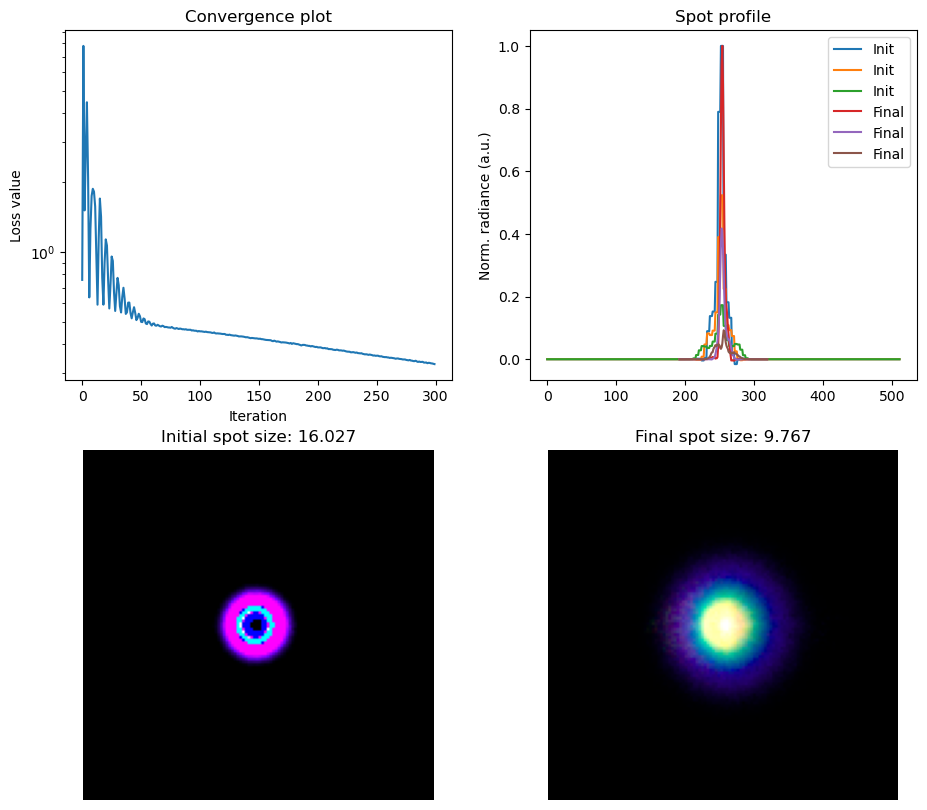

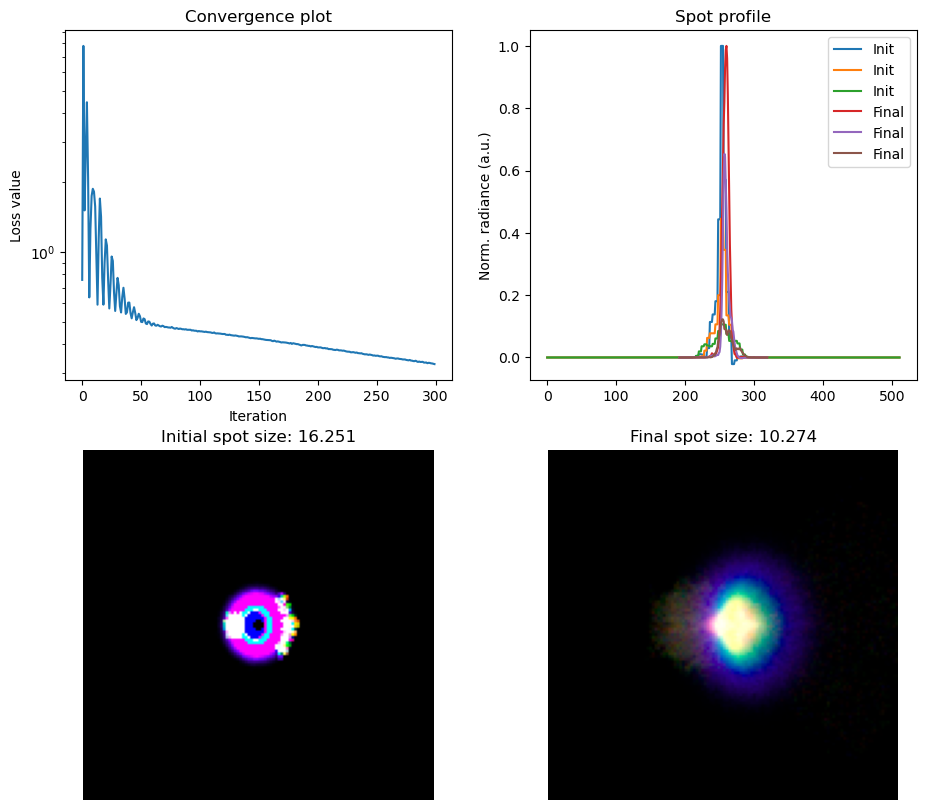

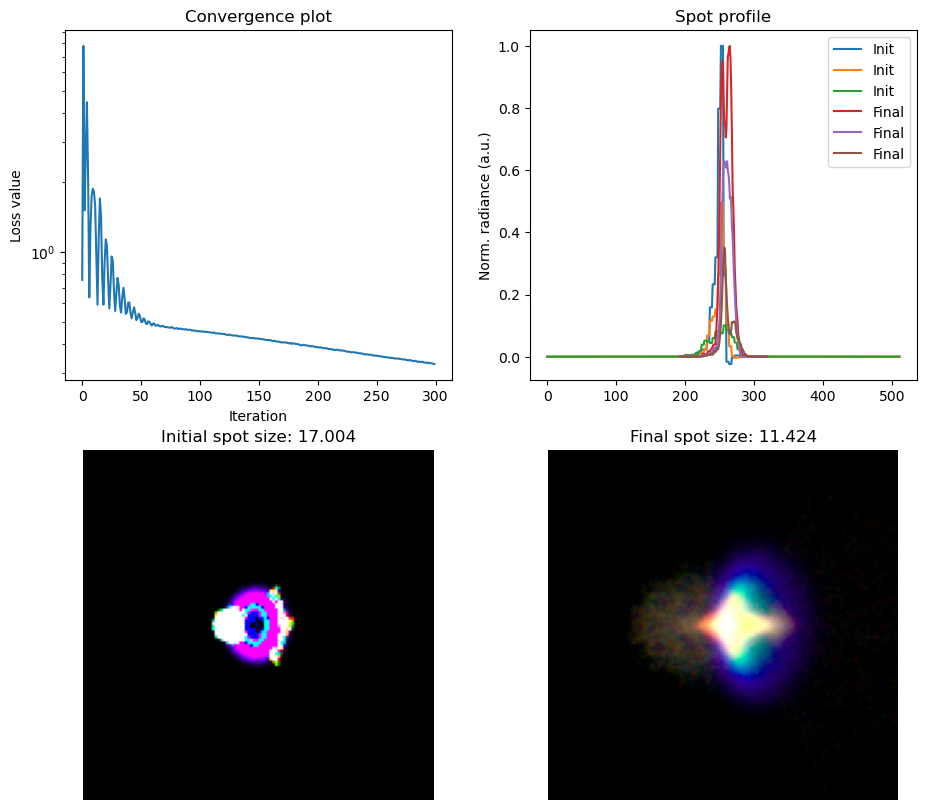

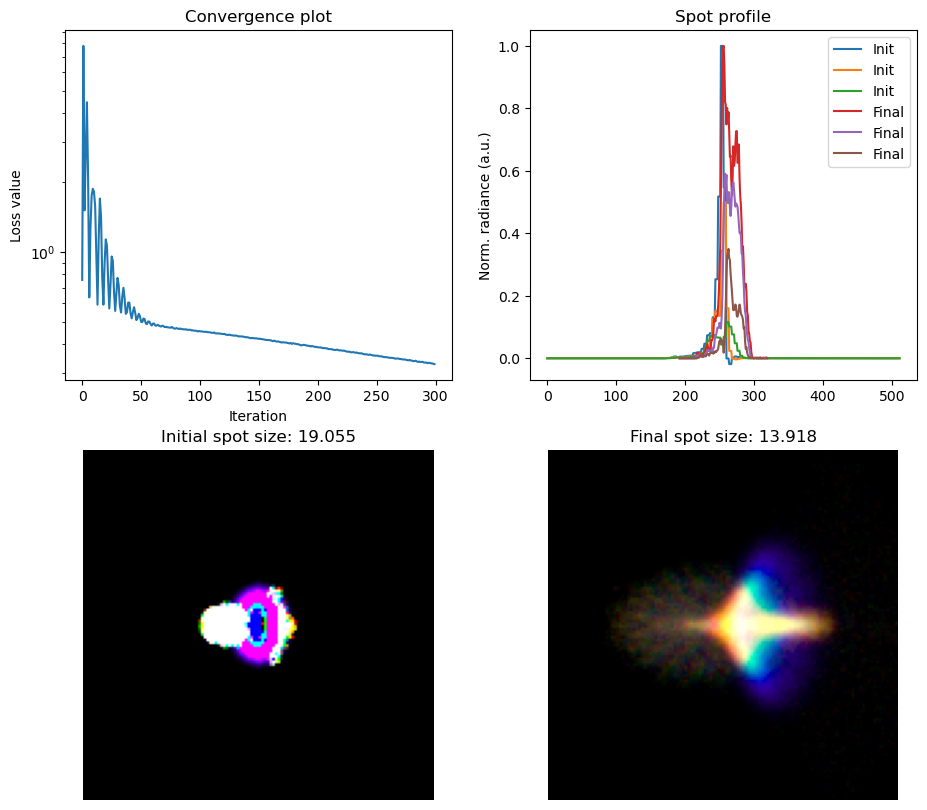

In [14]:
from scripts.lens_design.design_problem import plot_progress

for image_i, image_f in zip(images_init, images_final):
    _ = plot_progress(image_i, image_f, losses, upsample_steps, False)
    # mi.util.write_bitmap("spot_i.exr", image_i)
    # mi.util.write_bitmap("spot_f.exr", image_f)


In [15]:
print(problem.lens_system.materials[0].params)
print(problem.lens_system.materials[1].params)
print(problem.lens_system.elements[0].surface.params)
print(problem.lens_system.elements[1].surface.params)

{'ior': 1.000277, 'V_d': 0.0}
{'ior': 1.62041, 'V_d': 60.32}
{'c': [-0.05792970210313797], 'K': [4.32249089499237e-06], 'z0': [43.055789947509766], 'a4': [1.4103961802902631e-06], 'a6': 0.0, 'a8': 0.0, 'a10': 0.0, 'a12': 0.0, 'a14': 0.0, 'a16': 0.0}
{'c': [0.007081308402121067], 'K': [1.925542392200441e-06], 'z0': [44.95000076293945], 'a4': [1.8452062704454875e-06], 'a6': 0.0, 'a8': 0.0, 'a10': 0.0, 'a12': 0.0, 'a14': 0.0, 'a16': 0.0}


In [16]:
# NOTE: need to write the updated meshes to disk before plotting
# problem.lens_system.meshplot_geometry()